In [1]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.distributions.gamma import Gamma
from matplotlib import pyplot as plt
import torch.distributions as D
from torch.distributions.mixture_same_family import MixtureSameFamily
from sklearn.neighbors import KernelDensity
from torch.distributions import constraints
from torch.distributions.transforms import PowerTransform

import random

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['text.usetex'] = True

In [3]:
class NoisyDistApproxKD(nn.Module):

    def __init__(self, dist, sigma_list, n_simulate=100000):
        super(NoisyDistApproxKD, self).__init__()

        self.dist = dist
        self.sigma_list = sigma_list

        bandwidth = [1.06*max(1.0,sigma)*n_simulate**(-1/5) for sigma in self.sigma_list]

        self.kde_list = [KernelDensity(kernel='gaussian', bandwidth=bandwidth[idx]) for idx in range(len(self.sigma_list))]
        self.n_simulate = n_simulate
        self._get_table()


    def _get_table(self):

        noisy_sample_list = self.sample_array(self.n_simulate)
        noisy_sample_list = noisy_sample_list.numpy()
        [self.kde_list[idx].fit(noisy_sample_list[:,idx,None]) for idx in range(len(self.sigma_list))]


    def sample_array_(self, n_sample):

        # val = [self.dist.sample((n_sample,)) for _ in range(len(self.sigma_list))]
        # return torch.hstack(val)

        # p = Normal(torch.zeros(1), torch.sqrt(torch.ones(1)+self.sigma_list[0]**2))
        # val = [p.sample((n_sample,)) for _ in range(len(self.sigma_list))]
        # return torch.hstack(val)

        samples_t = []
        for idx in range(3):
            p = Normal(self.dist.loc, torch.sqrt(self.dist.scale+self.sigma_list[idx]**2))
            samples_t.append(p.sample((n_sample,)))
            # print(p.log_prob(noisy_sample_list[:,idx]).size())
        return torch.hstack(samples_t)


    def log_prob_array_(self, sample):

        # val = [self.dist.log_prob(sample[:,i]) for i in range(len(self.sigma_list))]
        # return torch.vstack(val).T

        # p = Normal(torch.zeros(1), torch.sqrt(torch.ones(1)+self.sigma_list[0]**2))
        # val = [p.log_prob(sample[:,i]) for i in range(len(self.sigma_list))]
        # return torch.vstack(val).T

        val_t = []
        for idx in range(3):
            p = Normal(self.dist.loc, torch.sqrt(self.dist.scale+self.sigma_list[idx]**2))
            val_t.append(p.log_prob(sample[:,idx]))
            # print(p.log_prob(noisy_sample_list[:,idx]).size())
        return torch.vstack(val_t).T


    def sample_array(self, n_sample):

        original_sample = self.dist.sample((n_sample,))
        noisy_sample_list = [original_sample+torch.randn(original_sample.size())*self.sigma_list[i] for i in range(len(self.sigma_list))]
        [noisy_sample_list[idx].squeeze_() for idx in range(len(noisy_sample_list))]
        # print(noisy_sample_list[0].size())
        # print(torch.vstack(noisy_sample_list).T.size())
        return torch.vstack(noisy_sample_list).T


    def log_prob_array(self, noisy_sample_list):

        val = [torch.tensor(self.kde_list[idx].score_samples(noisy_sample_list[:,idx,None])) for idx in range(len(self.sigma_list))]
        val = torch.vstack(val).T

        return val


def njsd_array_KD(p_dist, q_dist, n_sample, sigma_list, n_simulate):

    p_dist_n = NoisyDistApproxKD(p_dist, sigma_list, n_simulate)
    q_dist_n = NoisyDistApproxKD(q_dist, sigma_list, n_simulate)

    p_sample_n = p_dist_n.sample_array(n_sample)
    q_sample_n = q_dist_n.sample_array(n_sample)

    log_p_p = p_dist_n.log_prob_array(p_sample_n)
    log_q_p = q_dist_n.log_prob_array(p_sample_n)
    # log_q_p_ = q_dist_n.log_prob_array_(p_sample_n)
    # foo(p_sample_n, log_q_p, log_q_p_)
    log_pq_p = torch.logsumexp(torch.stack([log_p_p,log_q_p], dim=2), 2)

    log_p_q = p_dist_n.log_prob_array(q_sample_n)
    log_q_q = q_dist_n.log_prob_array(q_sample_n)
    log_pq_q = torch.logsumexp(torch.stack([log_p_q,log_q_q], dim=2), 2)

    return 0.5*(log_p_p.mean(0)-log_pq_p.mean(0)+log_q_q.mean(0)-log_pq_q.mean(0)+2*torch.log(torch.tensor(2)))


def gmm(weight, loc, scale):
    mix = D.Categorical(weight)
    comp = D.Normal(loc, scale)
    return MixtureSameFamily(mix, comp)

## Two Gaussian Distribution

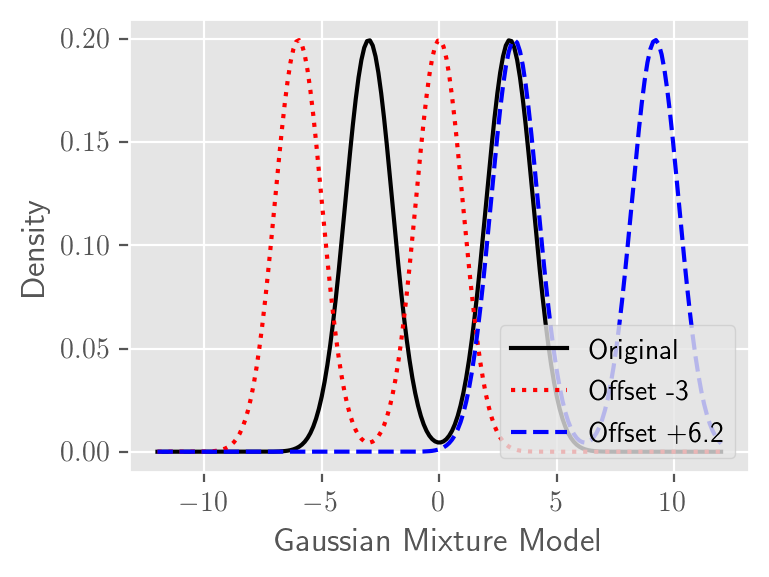

In [44]:
kwargs_x0 = {
    "weight": torch.ones(2,),
    "loc": torch.tensor([-3.,3.]),
    "scale": torch.ones(2,),
}

kwargs_x1 = {
    "weight": torch.ones(2,),
    "loc": torch.tensor([-3.,3.])-3,
    "scale": torch.ones(2,),
}

kwargs_x2 = {
    "weight": torch.ones(2,),
    "loc": torch.tensor([-3.,3.])+6.2,
    "scale": torch.ones(2,),
}

plt.figure(figsize=torch.tensor([4,3])*1, dpi=200)
x_sample = torch.linspace(-12, 12, 200)
plt.plot(x_sample, gmm(**kwargs_x0).log_prob(x_sample).exp(), 'k', label="Original")
plt.plot(x_sample, gmm(**kwargs_x1).log_prob(x_sample).exp(), 'r:', label="Offset -3")
plt.plot(x_sample, gmm(**kwargs_x2).log_prob(x_sample).exp(), 'b--', label="Offset +6.2")
plt.legend(loc='lower right')
plt.ylabel('Density')
plt.xlabel('Gaussian Mixture Model')
#plt.title("Two MoGs with small and big overlapping")
plt.show()

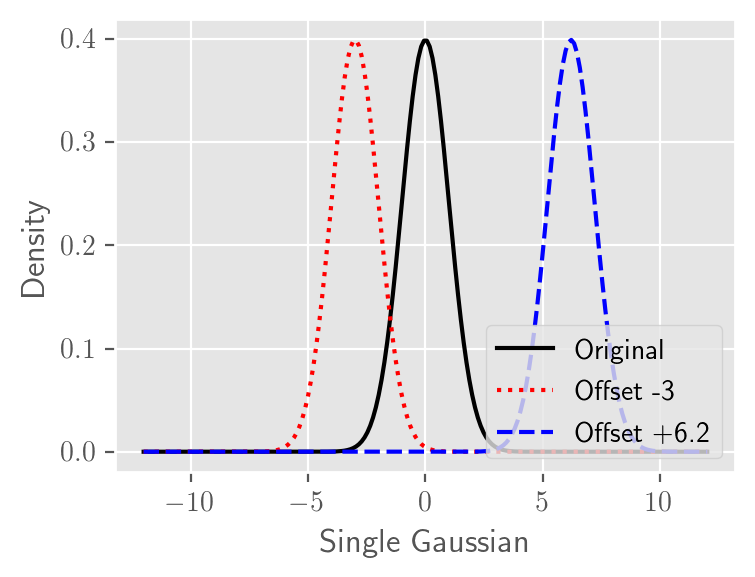

In [42]:
kwargs_x0 = {
    "weight": torch.ones(1,),
    "loc": torch.tensor([0]),
    "scale": torch.ones(1,),
}

kwargs_x1 = {
    "weight": torch.ones(1,),
    "loc": torch.tensor([-3]),
    "scale": torch.ones(1,),
}

kwargs_x2 = {
    "weight": torch.ones(1,),
    "loc": torch.tensor([6.2]),
    "scale": torch.ones(1,),
}

plt.figure(figsize=torch.tensor([4,3])*1, dpi=200)
x_sample = torch.linspace(-12, 12, 200)
plt.plot(x_sample, gmm(**kwargs_x0).log_prob(x_sample).exp(), 'k', label="Original")
plt.plot(x_sample, gmm(**kwargs_x1).log_prob(x_sample).exp(), 'r:', label="Offset -3")
plt.plot(x_sample, gmm(**kwargs_x2).log_prob(x_sample).exp(), 'b--', label="Offset +6.2")
plt.legend(loc='lower right')
plt.ylabel('Density')
plt.xlabel('Single Gaussian')
#plt.title("Two MoGs with small and big overlapping")
plt.show()

In [30]:
x_tick = torch.linspace(-12, 12, steps=20) 
#x_tick = torch.linspace(-12, 12, steps=10)
#sigma_list = torch.hstack([torch.tensor(0.0), torch.linspace(0.1, 3, 5)]).numpy()
sigma_list = torch.hstack([torch.tensor(0.0), torch.logspace(torch.log10(torch.tensor(0.5)), torch.log10(torch.tensor(3)), 4)]).numpy()
print(sigma_list)
n_simulate = 1000
n_sample = 10000

loc = torch.tensor([-3.,3.])
scale = torch.ones(2,)
def p(x):
    mix = D.Categorical(torch.ones(2,))
    comp = D.Normal(loc+x, scale)
    return MixtureSameFamily(mix, comp)

jsd_x = []
for idx,x in enumerate(x_tick):
    jsd_x.append(njsd_array_KD(p(0), p(x), n_sample, sigma_list, n_simulate))
    print(f"{idx}", end=" ")

# jsd_x = [njsd_array_KD(p(0), p(x), n_sample, sigma_list, n_simulate) for x in x_tick]
jsd_x = torch.vstack(jsd_x)

[0.         0.49999997 0.9085603  1.6509637  3.        ]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

Text(0.5, 0, 'Translation Parameter')

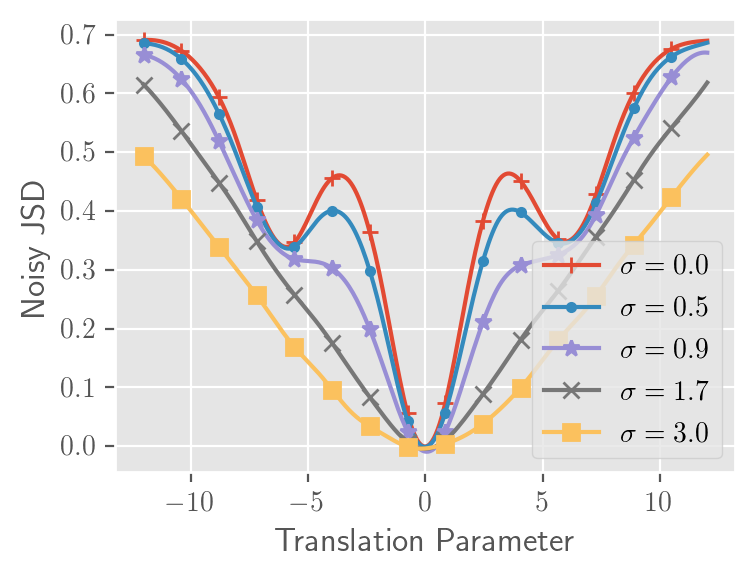

In [31]:
plt.figure(figsize=torch.tensor([4,3])*1, dpi=200)
# plt.plot(x_tick, jsd_x, label='JSD')
import itertools
markers = itertools.cycle(('+', '.', '*','x','s','d',',')) 

from scipy.interpolate import make_interp_spline, BSpline

for idx, marker in zip(range(len(sigma_list)), markers):
    x = x_tick
    y = jsd_x[:,idx]
    xnew = torch.linspace(x_tick.min(), x_tick.max(), 300) 
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    ynew = spl(xnew)
    plt.plot(xnew, ynew, marker=marker, markevery=20, label=f'$\sigma={sigma_list[idx]:.1f}$')
    #plt.plot(x_tick, jsd_x[:,idx], marker=marker, markevery=5, label=f'$\sigma={sigma_list[idx]:.1f}$')
plt.legend(loc='lower right')
plt.ylabel('Noisy JSD')
plt.xlabel('Translation Parameter')
#plt.title("JSD between noise injected MOG Distributions")

In [32]:
x_tick = torch.linspace(-12, 12, 20)
#x_tick = torch.linspace(-12, 12, 10)
#sigma_list = torch.hstack([torch.tensor(0.0), torch.linspace(0.1, 3, 5)]).numpy()
sigma_list = torch.hstack([torch.tensor(0.0), torch.logspace(torch.log10(torch.tensor(0.5)), torch.log10(torch.tensor(5)), 4)]).numpy()
print(sigma_list)
n_simulate = 1000
n_sample = 10000

loc = torch.tensor([0.])
scale = torch.ones(1,)
def p(x):
    mix = D.Categorical(torch.ones(1,))
    comp = D.Normal(loc+x, scale)
    return MixtureSameFamily(mix, comp)

jsd_x = []
for idx,x in enumerate(x_tick):
    jsd_x.append(njsd_array_KD(p(0), p(x), n_sample, sigma_list, n_simulate))
    print(f"{idx}", end=" ")

# jsd_x = [njsd_array_KD(p(0), p(x), n_sample, sigma_list, n_simulate) for x in x_tick]
jsd_x = torch.vstack(jsd_x)

[0.         0.49999997 1.0772173  2.3207946  5.        ]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

Text(0.5, 0, 'Translation Parameter')

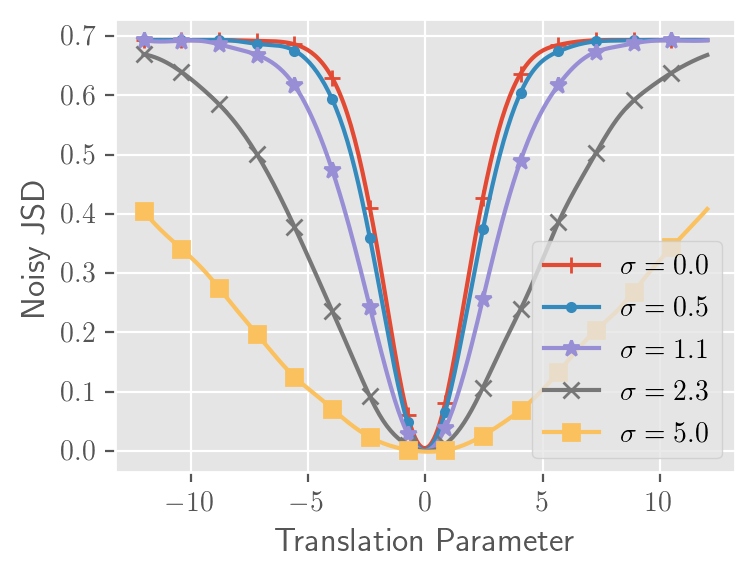

In [34]:
plt.figure(figsize=torch.tensor([4,3])*1, dpi=200)
import itertools
markers = itertools.cycle(('+', '.', '*','x','s','d',',')) 
for idx, marker in zip(range(len(sigma_list)), markers):
    x = x_tick
    y = jsd_x[:,idx]
    xnew = torch.linspace(x_tick.min(), x_tick.max(), 300) 
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    ynew = spl(xnew)
    plt.plot(xnew, ynew, marker=marker, markevery=20, label=f'$\sigma={sigma_list[idx]:.1f}$')
    #plt.plot(x_tick, jsd_x[:,idx], marker=marker, markevery=5, label=f'$\sigma={sigma_list[idx]:.1f}$')
plt.legend(loc='lower right')
plt.ylabel('Noisy JSD')
plt.xlabel('Translation Parameter')